#### Importing and organizing data

In [1]:
import kagglehub
import shutil
import os

# Download the dataset (cached path)
cached_path = kagglehub.dataset_download("roudranildas/chicken-images-classification-dataset")

# Define target path (working directory)
target_path = "/content/"

# Copy from cache to working directory
shutil.copytree(cached_path, target_path, dirs_exist_ok=True)

# New structure path
base_dir = "/content/organized-data"
splits = ['train', 'val', 'test']
classes = ['chicken', 'duck']

# Create new folders
for split in splits:

    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Copy files
for cls in classes:
    src_root = f"/content/data/{cls}-images/data"
    for split in splits:
        src = os.path.join(src_root, split)
        dst = os.path.join(base_dir, split, cls)
        for file in os.listdir(src):
            shutil.copy(os.path.join(src, file), dst)


# Step 1:  Import necessary libraries

In [2]:
# Step 1: Setup
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Step 2: Load dataset

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_dir = "/content/organized-data"

train_ds = datasets.ImageFolder(root=os.path.join(base_dir, 'train'), transform=transform)
val_ds = datasets.ImageFolder(root=os.path.join(base_dir, 'val'), transform=transform)
test_ds = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

print("Classes:", train_ds.classes)

Classes: ['chicken', 'duck']


# Step 3: Load pre-trained model

In [4]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Chicken vs Duck
for param in model.parameters():
    param.requires_grad = False  # freeze all layers

# Unfreeze the final classification layer
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Step 4: Training

In [7]:
# num_epochs = 50

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         # Forward + Backward + Optimize
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # Validation step
#     val_loss, val_acc = evaluate(model, val_loader)

#     print(f"Epoch [{epoch+1}/{num_epochs}]")
#     print(f"Train Loss: {running_loss/len(train_loader):.4f} | "
#           f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")


In [8]:
train_losses = []
val_losses = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    # Store for graph
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    # Print every 5 epochs (or final epoch)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")

Epoch [5/50]
Train Loss: 0.3826 | Val Loss: 0.3675 | Val Acc: 86.96%

Epoch [10/50]
Train Loss: 0.2791 | Val Loss: 0.2811 | Val Acc: 88.20%

Epoch [15/50]
Train Loss: 0.2103 | Val Loss: 0.2544 | Val Acc: 90.06%

Epoch [20/50]
Train Loss: 0.2188 | Val Loss: 0.2413 | Val Acc: 90.68%

Epoch [25/50]
Train Loss: 0.1863 | Val Loss: 0.2200 | Val Acc: 92.55%

Epoch [30/50]
Train Loss: 0.1515 | Val Loss: 0.2032 | Val Acc: 91.30%

Epoch [35/50]
Train Loss: 0.1473 | Val Loss: 0.1961 | Val Acc: 91.30%

Epoch [40/50]
Train Loss: 0.1494 | Val Loss: 0.2040 | Val Acc: 91.30%

Epoch [45/50]
Train Loss: 0.1198 | Val Loss: 0.2073 | Val Acc: 92.55%

Epoch [50/50]
Train Loss: 0.1227 | Val Loss: 0.2013 | Val Acc: 91.93%



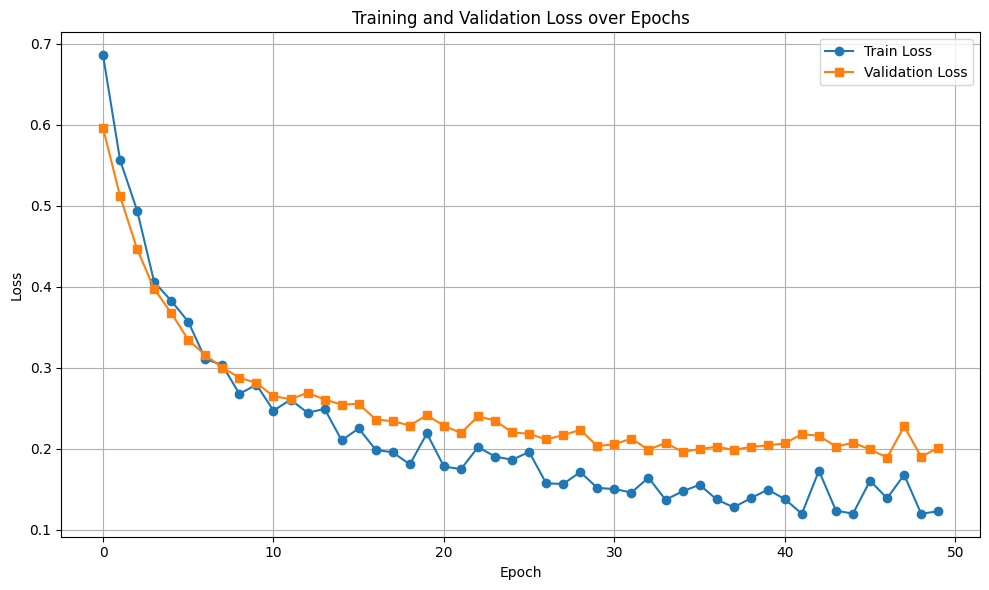

In [9]:
# Plotting after training
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='s')
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 6: Evaluate the Model on Test Data

In [10]:
def generate_classification_report(model, dataloader, class_names, device, name=""):
    model.eval()
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                images, labels = batch
            else:
                images = batch
                labels = None  # Just in case, unlikely in this use case

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            preds_list.extend(preds.cpu().tolist())
            labels_list.extend(labels.cpu().tolist())

    print(f"\n📊 Classification Report - {name} Set\n")
    print(classification_report(labels_list, preds_list, target_names=class_names))


In [11]:
class_names = train_ds.classes
generate_classification_report(model, test_loader, class_names, device, name="Test")


📊 Classification Report - Test Set

              precision    recall  f1-score   support

     chicken       0.98      0.89      0.93       172
        duck       0.94      0.99      0.97       310

    accuracy                           0.95       482
   macro avg       0.96      0.94      0.95       482
weighted avg       0.96      0.95      0.95       482



In [12]:
generate_classification_report(model, val_loader, class_names, device, name="Validation")


📊 Classification Report - Validation Set

              precision    recall  f1-score   support

     chicken       0.98      0.77      0.86        52
        duck       0.90      0.99      0.94       109

    accuracy                           0.92       161
   macro avg       0.94      0.88      0.90       161
weighted avg       0.92      0.92      0.92       161



In [13]:
generate_classification_report(model, train_loader, class_names, device, name="Train")


📊 Classification Report - Train Set

              precision    recall  f1-score   support

     chicken       0.98      0.93      0.95       275
        duck       0.97      0.99      0.98       622

    accuracy                           0.97       897
   macro avg       0.97      0.96      0.97       897
weighted avg       0.97      0.97      0.97       897

